In [1]:
# Importing necessary libraries for the full pipeline
import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy.signal import wiener
from skimage import exposure, morphology, segmentation, filters
import pywt
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.utils import make_grid


In [2]:


# Unzip
zip_path = "D:\PinkRangers\Augmented_Breast_Thermography.zip"
extract_path = "D:\PinkRangers\Augmented_Breast_Thermography"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
print(f" Dataset extracted to: {extract_path}")

 Dataset extracted to: D:\PinkRangers\Augmented_Breast_Thermography


In [3]:
import os
import cv2
import numpy as np

IMG_SIZE = (128, 128)
DATASET_PATH =  "D:\PinkRangers\Augmented_Breast_Thermography"

def load_original_images(dataset_path):
    raw_images = []
    labels = []

    for label_folder in ["Benign", "Malignant"]:
        label = label_folder
        class_dir = os.path.join(dataset_path, label_folder)

        for subfolder in os.listdir(class_dir):
            subfolder_path = os.path.join(class_dir, subfolder)
            if os.path.isdir(subfolder_path):
                for file in os.listdir(subfolder_path):
                    img_path = os.path.join(subfolder_path, file)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, IMG_SIZE)
                        raw_images.append(img)
                        labels.append(label)

    return np.array(raw_images), np.array(labels)

# Load only original grayscale images and labels
X_raw, y_raw = load_original_images(DATASET_PATH)


In [14]:
import os
import cv2
import numpy as np
from scipy.signal import wiener
from skimage import exposure
from tqdm import tqdm

IMG_SIZE = (128, 128)
DATASET_PATH = "D:\PinkRangers\Augmented_Breast_Thermography"

def load_preprocess_images(dataset_path):
    images = []
    labels = []

    for label_folder in ["Benign", "Malignant"]:
        label = label_folder  # Use string label directly: "Benign" or "Malignant"
        class_dir = os.path.join(dataset_path, label_folder)

        for subfolder in os.listdir(class_dir):
            subfolder_path = os.path.join(class_dir, subfolder)
            if os.path.isdir(subfolder_path):
                for file in os.listdir(subfolder_path):
                    img_path = os.path.join(subfolder_path, file)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, IMG_SIZE)
                        img = img.astype(np.float32) / 255.0  # Normalize
                        with np.errstate(divide='ignore', invalid='ignore'):
                            img_wiener = wiener(img)
                            img_wiener = np.nan_to_num(img_wiener)
                        img_eq = exposure.equalize_hist(img_wiener)
                        img_eq = (img_eq * 255).astype(np.uint8)
                        images.append(img_eq)
                        labels.append(label)
    return np.array(images), np.array(labels)

X_preprocessed, y = load_preprocess_images(DATASET_PATH)


In [15]:
from skimage import filters, morphology, segmentation, color

def apply_watershed_segmentation(images):
    segmented_images = []
    for img in tqdm(images):
        gradient = filters.rank.gradient(img, morphology.disk(2))
        markers = filters.rank.gradient(img, morphology.disk(4)) < 10
        markers = morphology.label(markers)
        labels_ws = segmentation.watershed(gradient, markers)
        segmented_rgb = color.label2rgb(labels_ws, image=img, bg_label=0)
        segmented_gray = cv2.cvtColor((segmented_rgb * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        segmented_images.append(segmented_gray)
    return np.array(segmented_images)

X_segmented = apply_watershed_segmentation(X_preprocessed)


100%|██████████| 10353/10353 [01:10<00:00, 146.52it/s]


In [7]:
import pywt

def extract_wavelet_features(images, wavelet='db4'):
    wavelet_features = []
    for img in images:
        coeffs2 = pywt.dwt2(img, wavelet)
        cA, (cH, cV, cD) = coeffs2
        features = [
            np.mean(cA), np.std(cA),
            np.mean(cH), np.std(cH),
            np.mean(cV), np.std(cV),
            np.mean(cD), np.std(cD)
        ]
        wavelet_features.append(features)
    return np.array(wavelet_features)

X_wavelet = extract_wavelet_features(X_segmented)


In [8]:
from sklearn.svm import OneClassSVM

svm_model = OneClassSVM(kernel='rbf', nu=0.1, gamma='auto')
svm_model.fit(X_wavelet)

# Predict anomaly (-1 for outliers, 1 for inliers)
pred_anomaly = svm_model.predict(X_wavelet)
print("Anomalies Detected:", np.sum(pred_anomaly == -1))


Anomalies Detected: 1113


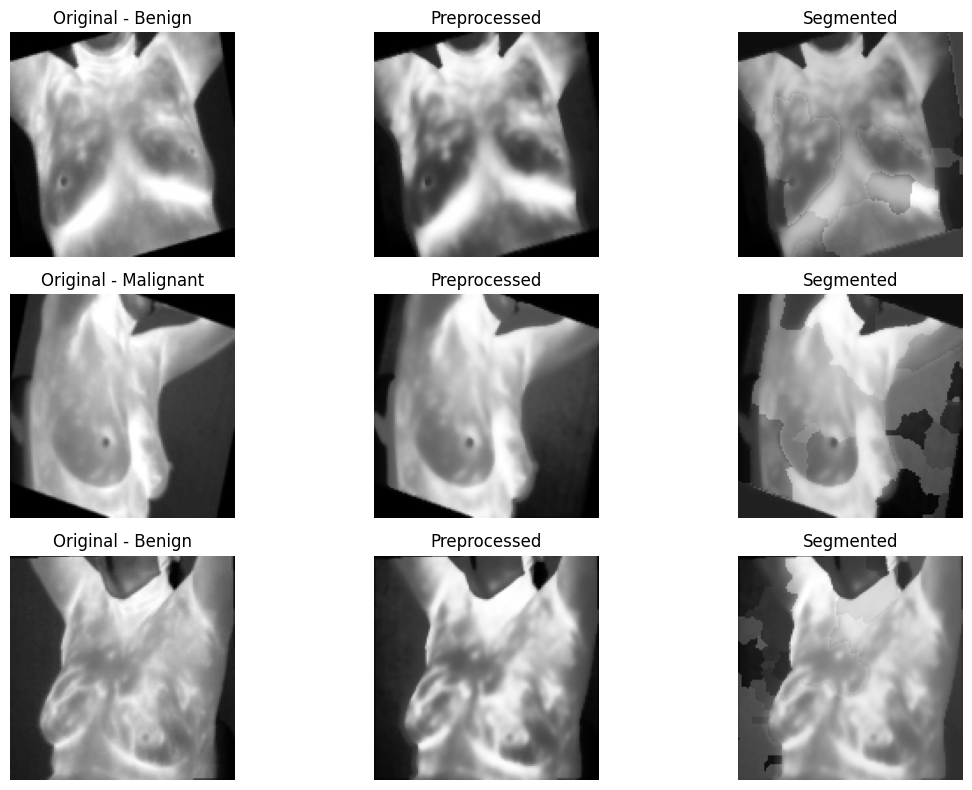

In [10]:
import matplotlib.pyplot as plt
import random

indices = random.sample(range(len(X_preprocessed)), 3)
plt.figure(figsize=(12, 8))

for i, idx in enumerate(indices):
    plt.subplot(3, 3, i*3 + 1)
    plt.imshow(X_raw[idx], cmap='gray')
    plt.title(f"Original - {y_raw[idx]}")
    plt.axis('off')

    plt.subplot(3, 3, i*3 + 2)
    plt.imshow(X_preprocessed[idx], cmap='gray')
    plt.title("Preprocessed")
    plt.axis('off')

    plt.subplot(3, 3, i*3 + 3)
    plt.imshow(X_segmented[idx], cmap='gray')
    plt.title("Segmented")
    plt.axis('off')

plt.tight_layout()
plt.show()


# CNN MODEL AFTER WEINER FILTER+ HISTOGRAM EQUALIZATION 

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)


c:\Users\Shakthi\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.5879 - loss: 0.7367 - val_accuracy: 0.7228 - val_loss: 9.5643
Epoch 2/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - accuracy: 0.7238 - loss: 0.5386 - val_accuracy: 0.5698 - val_loss: 72.1008
Epoch 3/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - accuracy: 0.8227 - loss: 0.3861 - val_accuracy: 0.5620 - val_loss: 124.4749
Epoch 4/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - accuracy: 0.8807 - loss: 0.2774 - val_accuracy: 0.8730 - val_loss: 29.3111
Epoch 5/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.9354 - loss: 0.1754 - val_accuracy: 0.8894 - val_loss: 25.8293
Epoch 6/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - accuracy: 0.9609 - loss: 0.1112 - val_accuracy: 0.8914 - val_loss: 26.3447
Epoch 7/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.9700 - loss: 0.0825 - val_accuracy: 0.8397 - val_loss: 47.6536
Epoch 8/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.9801 - loss: 0.

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
CNN Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      1483
           1       0.65      0.97      0.78       588

    accuracy                           0.84      2071
   macro avg       0.82      0.88      0.83      2071
weighted avg       0.89      0.84      0.85      2071



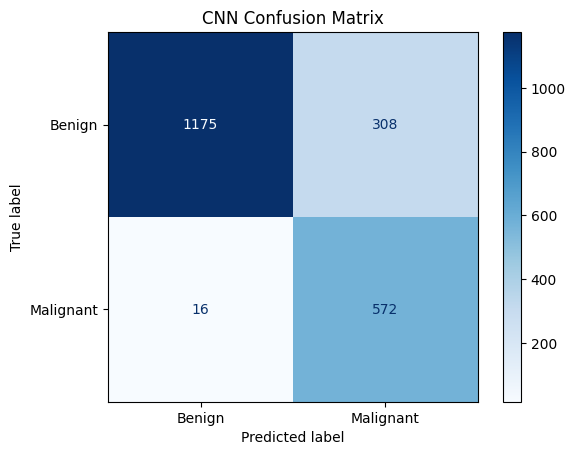

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt

# CNN Model
def create_cnn_model(input_shape=(128, 128, 1)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Sigmoid output for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Map labels to 0 (Benign) and 1 (Malignant)
y_train = np.where(y_train == 'Benign', 0, 1)
y_test = np.where(y_test == 'Benign', 0, 1)

# Ensure the labels are integers
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

# Ensure correct shape and types for X_train and y_train
X_train = X_train.astype(np.float32) / 255.0  # Normalize
X_train = np.expand_dims(X_train, axis=-1)  # Add channel dimension if not already present

# Calculate class weights (this will handle class imbalance)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}  # Benign: 0, Malignant: 1

# Create and train the CNN model
cnn_model = create_cnn_model()

# Train the model with class weights
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weight_dict)

# Save the model
cnn_model.save('cnn_model_preprocessed.h5')

# Evaluate the CNN Model
y_pred_cnn = (cnn_model.predict(X_test) > 0.5).astype("int32")

# Print classification report
print("CNN Classification Report:")
print(classification_report(y_test, y_pred_cnn))

# Confusion Matrix for CNN
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
ConfusionMatrixDisplay(confusion_matrix=cm_cnn,display_labels=["Benign", "Malignant"]).plot(cmap='Blues')
plt.title("CNN Confusion Matrix")
plt.show()


In [3]:
from tensorflow.keras.models import load_model

# Load the pre-trained CNN model
model = load_model('cnn_model_preprocessed.h5')  # or use 'cnn_model.h5' for the other


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


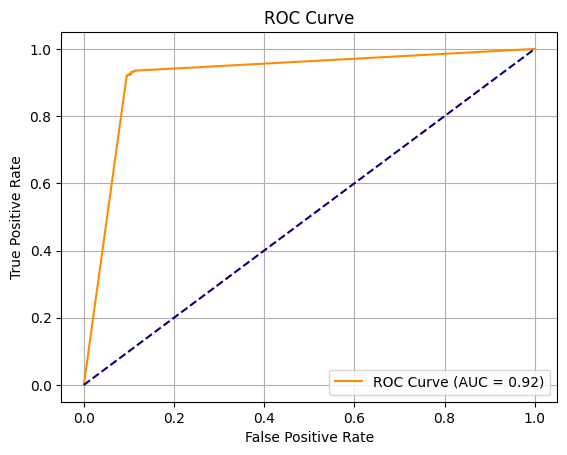

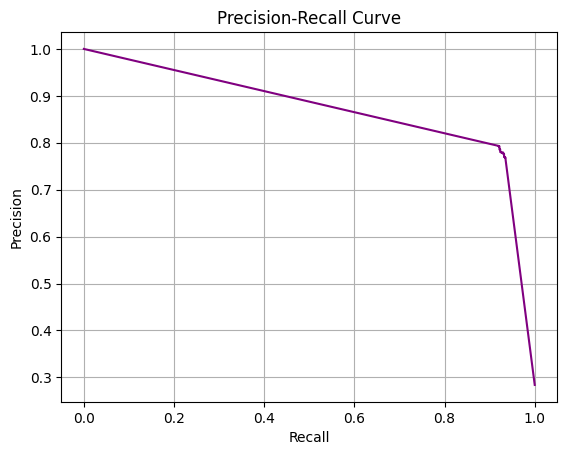

In [22]:

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# Convert categorical labels to binary labels
label_encoder = LabelEncoder()
y_test_binary = label_encoder.fit_transform(y_test)

# Get predicted probabilities
y_pred_prob = model.predict(X_test).ravel()

# ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc, color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_binary, y_pred_prob)

plt.figure()
plt.plot(recall, precision, color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


# CNN MODEL AFTER WEINER FILTER+ HISTOGRAM EQUALIZATION AND WATERSHED SEGMENTATION

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_segmented, y, test_size=0.2, random_state=42)


Epoch 1/10


c:\Users\Shakthi\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


259/259 ━━━━━━━━━━━━━━━━━━━━ 27s 98ms/step - accuracy: 0.5381 - loss: 0.7133 - val_accuracy: 0.6152 - val_loss: 27.2112
Epoch 2/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 24s 92ms/step - accuracy: 0.6660 - loss: 0.6253 - val_accuracy: 0.6514 - val_loss: 33.8385
Epoch 3/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - accuracy: 0.7376 - loss: 0.5238 - val_accuracy: 0.7422 - val_loss: 38.5288
Epoch 4/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.7978 - loss: 0.4196 - val_accuracy: 0.6697 - val_loss: 67.9438
Epoch 5/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 24s 93ms/step - accuracy: 0.8686 - loss: 0.3087 - val_accuracy: 0.7967 - val_loss: 44.4830
Epoch 6/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - accuracy: 0.9192 - loss: 0.2078 - val_accuracy: 0.7943 - val_loss: 53.7305
Epoch 7/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.9491 - loss: 0.1401 - val_accuracy: 0.7460 - val_loss: 88.3128
Epoch 8/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.9602 - loss: 0.1042 - val

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
CNN Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.72      0.82      1483
           1       0.57      0.92      0.70       588

    accuracy                           0.78      2071
   macro avg       0.76      0.82      0.76      2071
weighted avg       0.85      0.78      0.79      2071



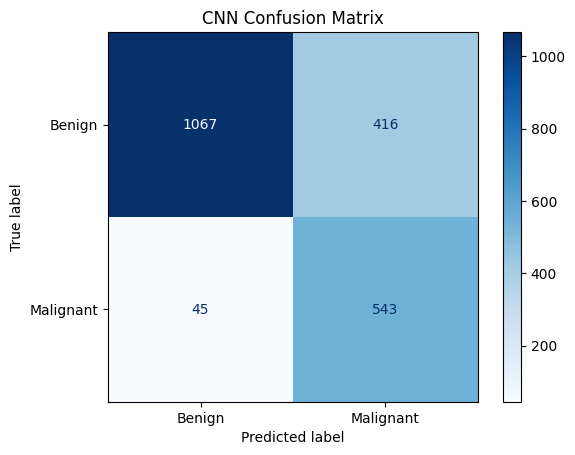

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt

# CNN Model
def create_cnn_model(input_shape=(128, 128, 1)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Sigmoid output for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Map labels to 0 (Benign) and 1 (Malignant)
y_train = np.where(y_train == 'Benign', 0, 1)
y_test = np.where(y_test == 'Benign', 0, 1)

# Ensure the labels are integers
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

# Ensure correct shape and types for X_train and y_train
X_train = X_train.astype(np.float32) / 255.0  # Normalize
X_train = np.expand_dims(X_train, axis=-1)  # Add channel dimension if not already present

# Calculate class weights (this will handle class imbalance)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}  # Benign: 0, Malignant: 1

# Create and train the CNN model
cnn_model = create_cnn_model()

# Train the model with class weights
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weight_dict)

# Save the model
cnn_model.save('cnn_model.h5')

# Evaluate the CNN Model
y_pred_cnn = (cnn_model.predict(X_test) > 0.5).astype("int32")

# Print classification report
print("CNN Classification Report:")
print(classification_report(y_test, y_pred_cnn))

# Confusion Matrix for CNN
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

# Display with class names
ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=["Benign", "Malignant"]).plot(cmap='Blues')
plt.title("CNN Confusion Matrix")
plt.show()



In [18]:
from tensorflow.keras.models import load_model

# Load the pre-trained CNN model
model = load_model('cnn_model.h5')  # or use 'cnn_model.h5' for the other


In [19]:


# Use same split strategy
X_train, X_test, y_train, y_test = train_test_split(X_segmented, y, test_size=0.2, random_state=42)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


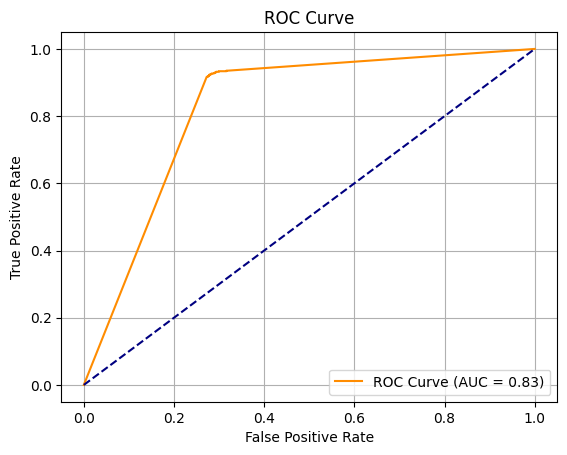

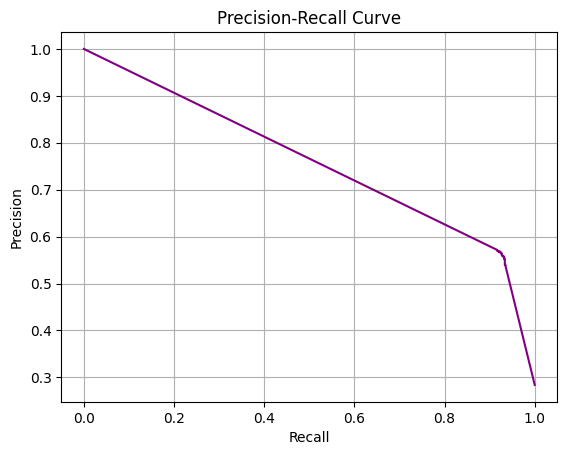

In [21]:
from sklearn.preprocessing import LabelEncoder

# Convert categorical labels to binary labels
label_encoder = LabelEncoder()
y_test_binary = label_encoder.fit_transform(y_test)

# Get predicted probabilities
y_pred_prob = model.predict(X_test).ravel()

# ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc, color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_binary, y_pred_prob)

plt.figure()
plt.plot(recall, precision, color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


# K means clustering

Classification Report (K-Means):
              precision    recall  f1-score   support

      Benign       0.71      1.00      0.83      7308
   Malignant       0.00      0.00      0.00      3045

    accuracy                           0.71     10353
   macro avg       0.35      0.50      0.41     10353
weighted avg       0.50      0.71      0.58     10353

Accuracy: 0.7058823529411765
Adjusted Rand Index (ARI): -7.101451634836005e-05


c:\Users\Shakthi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shakthi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shakthi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

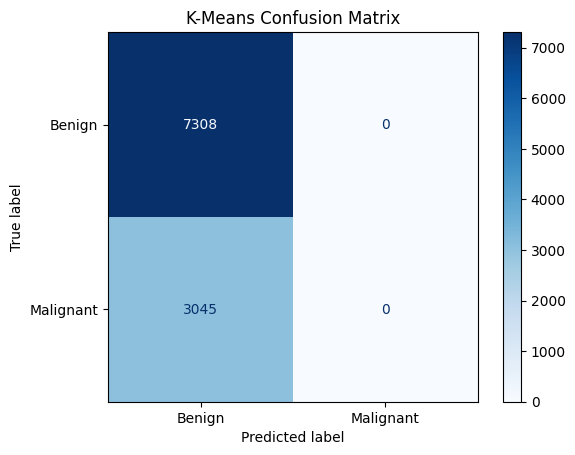

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode

# Encode string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_wavelet)

# Align cluster labels with actual labels using majority vote
aligned_labels = np.zeros_like(cluster_labels)
for i in range(2):
    mask = (cluster_labels == i)
    aligned_labels[mask] = mode(y_encoded[mask])[0]

# Evaluation Metrics
print("Classification Report (K-Means):")
print(classification_report(y_encoded, aligned_labels, target_names=["Benign", "Malignant"]))

print("Accuracy:", accuracy_score(y_encoded, aligned_labels))
print("Adjusted Rand Index (ARI):", adjusted_rand_score(y_encoded, cluster_labels))

# Confusion Matrix
cm = confusion_matrix(y_encoded, aligned_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot(cmap=plt.cm.Blues)
plt.title("K-Means Confusion Matrix")
plt.show()


# SVM Model

Classification Report:
              precision    recall  f1-score   support

      Benign       0.73      0.46      0.57      1483
   Malignant       0.30      0.58      0.39       588

    accuracy                           0.50      2071
   macro avg       0.52      0.52      0.48      2071
weighted avg       0.61      0.50      0.52      2071



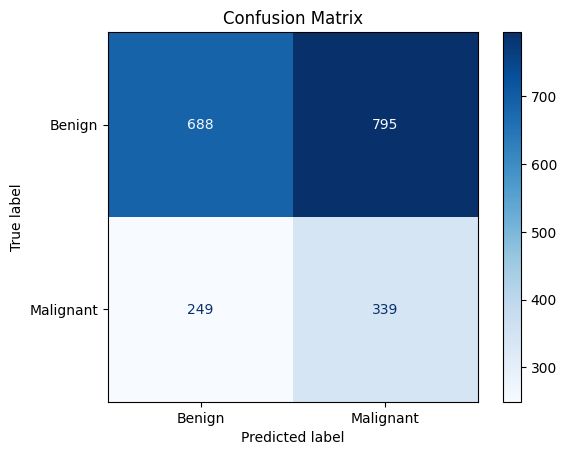

In [18]:

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_wavelet, y, test_size=0.2, random_state=42)

# SVM with class_weight
svm_model = SVC(kernel='rbf', gamma='scale', C=1.0, class_weight='balanced')
svm_model.fit(X_train, y_train)

# Predict
y_pred = svm_model.predict(X_test)

# Report
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix
labels = ['Benign', 'Malignant']
cm = confusion_matrix(y_test, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# RandomForestClassifier

              precision    recall  f1-score   support

      Benign       0.72      0.96      0.82      1483
   Malignant       0.34      0.05      0.09       588

    accuracy                           0.70      2071
   macro avg       0.53      0.51      0.46      2071
weighted avg       0.61      0.70      0.61      2071



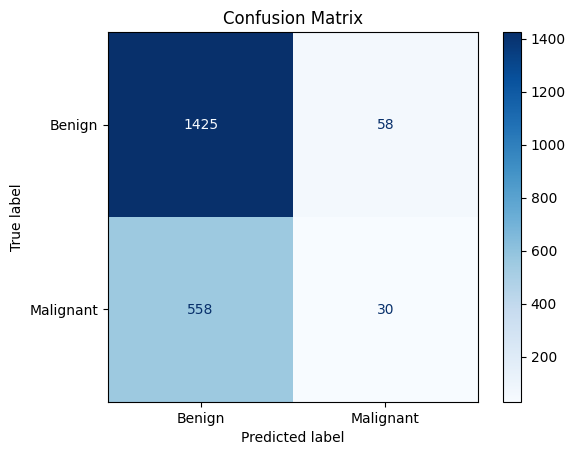

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_wavelet, y, test_size=0.2, random_state=42)
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
labels = ['Benign', 'Malignant']
cm = confusion_matrix(y_test, y_pred_rf, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# LogisticRegression


              precision    recall  f1-score   support

      Benign       0.72      0.99      0.83      1483
   Malignant       0.48      0.02      0.04       588

    accuracy                           0.72      2071
   macro avg       0.60      0.51      0.43      2071
weighted avg       0.65      0.72      0.61      2071



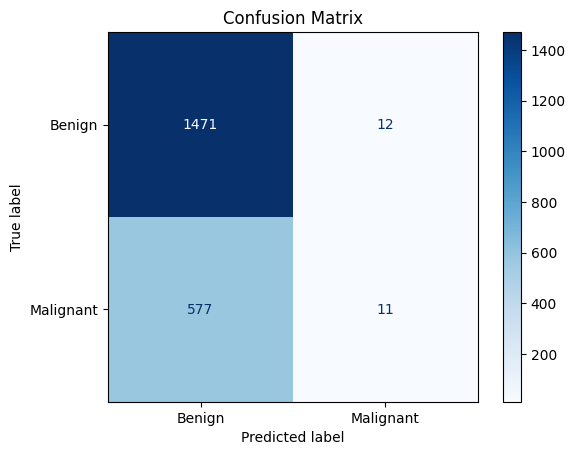

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_wavelet, y, test_size=0.2, random_state=42)
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix
labels = ['Benign', 'Malignant']
cm = confusion_matrix(y_test, y_pred_lr, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# XGBClassifier

              precision    recall  f1-score   support

      Benign       0.72      0.88      0.79      1483
   Malignant       0.31      0.13      0.19       588

    accuracy                           0.67      2071
   macro avg       0.52      0.51      0.49      2071
weighted avg       0.60      0.67      0.62      2071



c:\Users\Shakthi\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [18:04:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


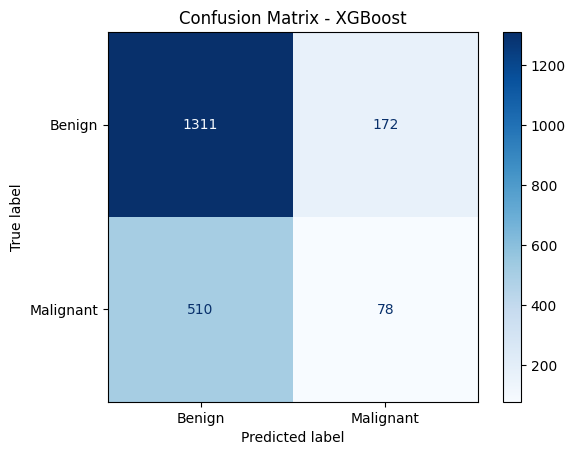

In [21]:
from sklearn.preprocessing import LabelEncoder

# Encode string labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # 'Benign' -> 0, 'Malignant' -> 1

# Now split using encoded labels
X_train, X_test, y_train, y_test = train_test_split(X_wavelet, y_encoded, test_size=0.2, random_state=42)

# Train XGBoost
from xgboost import XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

# Confusion matrix with correct labels
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost")
plt.show()
